# **Accident Severity Classification**

In [2]:


import numpy as np
import pandas as pd 
from datetime import datetime as dt
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from pandas.plotting import scatter_matrix
import warnings
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, OneHotEncoder, KBinsDiscretizer, MaxAbsScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
import seaborn as sns
sns.set()
import math

warnings.filterwarnings('ignore')
%matplotlib inline



import os
print(os.listdir(r"C:\Users\ayanb\Downloads\RS1"))



['Accident_Information.csv', 'Vehicle_Information.csv']


# **2. Data Preparation**
## **2.1 Load Data**

In [4]:
#Load Data and encode to latin
acc = pd.read_csv(r'C:\Users\ayanb\Downloads\RS1\Accident_Information.csv', encoding = 'latin')
veh = pd.read_csv(r'C:\Users\ayanb\Downloads\RS1\Vehicle_Information.csv', encoding = 'latin')

# Merging two data sets into one with inner join by index
df = pd.merge(veh, acc, how = 'inner', on = 'Accident_Index')

#Check data sample
print(df.shape)
df.head()

(2058408, 57)


,Accident_Index,Age_Band_of_Driver,Age_of_Vehicle,Driver_Home_Area_Type,Driver_IMD_Decile,Engine_Capacity_.CC.,Hit_Object_in_Carriageway,Hit_Object_off_Carriageway,Journey_Purpose_of_Driver,Junction_Location,...,Police_Force,Road_Surface_Conditions,Road_Type,Special_Conditions_at_Site,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Year_y,InScotland
0,200501BS00002,36 - 45,3.0,Data missing or out of range,NaN,8268.0,NaN,NaN,Journey as part of work,Leaving roundabout,...,Metropolitan Police,Dry,Dual carriageway,NaN,30.0,17:36,Urban,Fine no high winds,2005,No
1,200501BS00003,26 - 35,5.0,Urban area,3.0,8300.0,Parked vehicle,NaN,Journey as part of work,Not at or within 20 metres of junction,...,Metropolitan Police,Dry,Single carriageway,NaN,30.0,00:15,Urban,Fine no high winds,2005,No
2,200501BS00004,46 - 55,4.0,Urban area,1.0,1769.0,NaN,NaN,Other/Not known (2005-10),Not at or within 20 metres of junction,...,Metropolitan Police,Dry,Single carriageway,NaN,30.0,10:35,Urban,Fine no high winds,2005,No
3,200501BS00005,46 - 55,10.0,Data missing or out of range,NaN,85.0,Kerb,NaN,Other/Not known (2005-10),Not at or within 20 metres of junction,...,Metropolitan Police,Wet or damp,Single carriageway,NaN,30.0,21:13,Urban,Fine no high winds,2005,No
4,200501BS00006,46 - 55,1.0,Urban area,4.0,2976.0,NaN,NaN,Other/Not known (2005-10),Not at or within 20 metres of junction,...,Metropolitan Police,Wet or damp,Single carriageway,Oil or diesel,30.0,12:40,Urban,Raining no high winds,2005,No


## **2.2 Sample the data** 
### by reducing rows with Slight Accident Severity


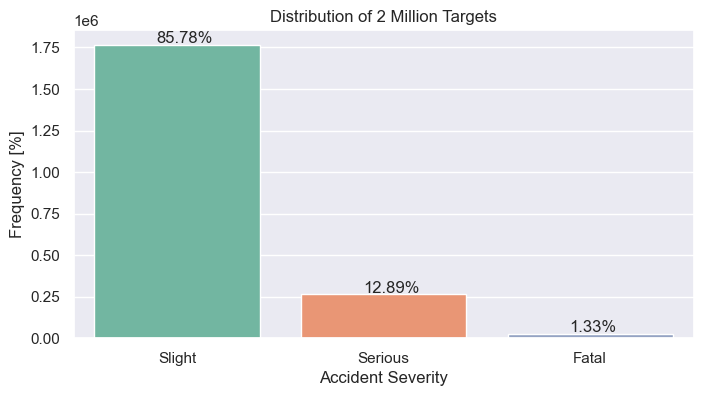

In [6]:
#Distribution of original data by targets

ax = sns.countplot(x = df.Accident_Severity ,palette="Set2")
sns.set(font_scale=1)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(8,4)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(df.Accident_Severity)), (p.get_x()+ 0.3, p.get_height()+10000))

plt.title('Distribution of 2 Million Targets',)
plt.xlabel('Accident Severity')
plt.ylabel('Frequency [%]')
plt.show()


In [7]:
# Creating weights that are opposite to the weights of target
weights = np.where(df['Accident_Severity'] == 'Slight', .2, .8)

#Sampling only 30% of the data with new weights  
df = df.sample(frac=0.3, replace=True, weights=weights)
print(df.shape)
#df.Accident_Severity.value_counts(normalize=True)

(617522, 57)


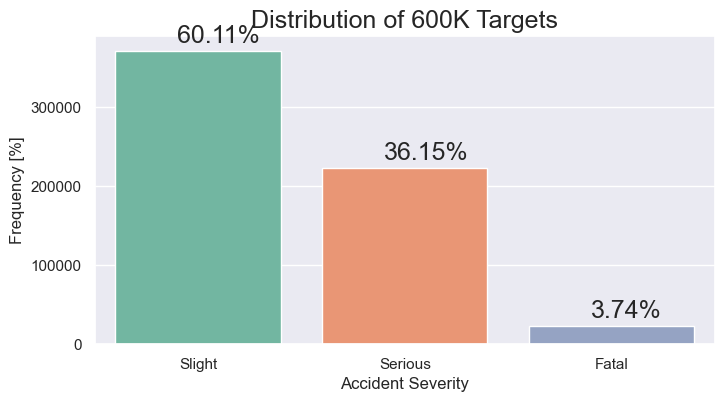

In [8]:
#Distribution of sample data by targets

ax = sns.countplot(x = df.Accident_Severity ,palette="Set2")
sns.set(font_scale=1.5)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(8,4)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(df.Accident_Severity)), (p.get_x()+ 0.3, p.get_height()+10000))

plt.title('Distribution of 600K Targets',)
plt.xlabel('Accident Severity')
plt.ylabel('Frequency [%]')
plt.show()


## **2.3 Check for missing values (NaN)**
### some will be filled, some will get omitted

In [10]:
#Missing values for each column
null_count = df.isnull().sum()
null_count[null_count>0]#.plot('bar', figsize=(30,10))

Age_of_Vehicle                                 102303
Driver_IMD_Decile                              205998
Engine_Capacity_.CC.                            75580
Hit_Object_in_Carriageway                      589907
Hit_Object_off_Carriageway                     555598
make                                            34153
model                                           96333
Propulsion_Code                                 70510
Skidding_and_Overturning                       528880
Vehicle_Location.Restricted_Lane                  333
2nd_Road_Class                                 263545
2nd_Road_Number                                  5834
Carriageway_Hazards                            606279
Did_Police_Officer_Attend_Scene_of_Accident        40
Latitude                                           28
Location_Easting_OSGR                              28
Location_Northing_OSGR                             28
Longitude                                          28
LSOA_of_Accident_Location   

## **2.4 Exploratory Visualization**
### **Age of Vehicle**

Min: 1.0 
Max: 91.0 
Median: 7.0


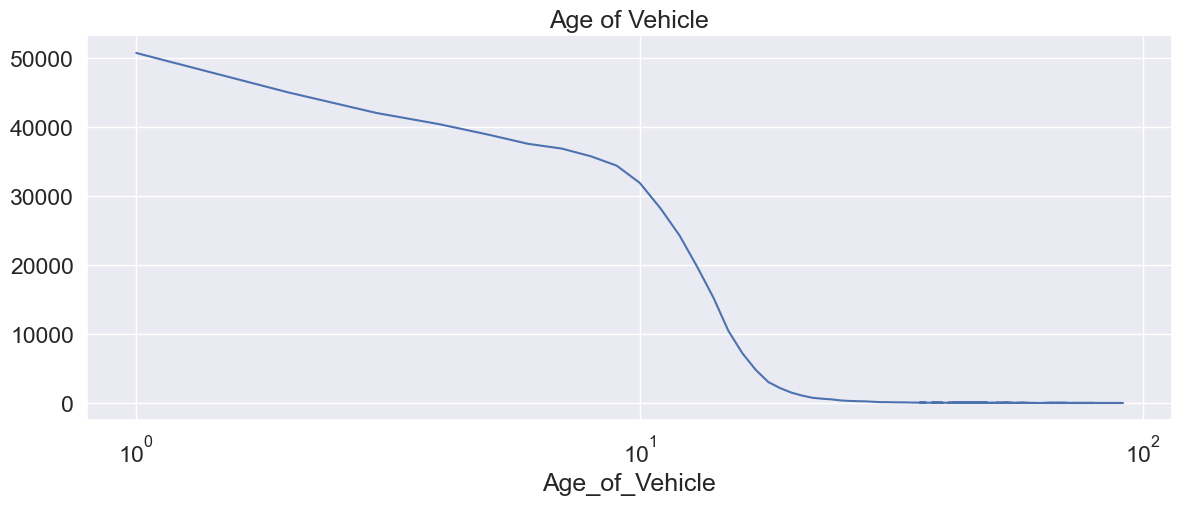

In [12]:
(df.Age_of_Vehicle
 .value_counts()
 .plot(title = "Age of Vehicle", 
       logx = True, 
       figsize=(14,5)))

print('Min:',    df.Age_of_Vehicle.min(), '\n'
      'Max:',    df.Age_of_Vehicle.max(), '\n'
      'Median:', df.Age_of_Vehicle.median())

### **Engine capacity feature**

Min: 1.0 
Max: 91000.0 
Median: 1598.0


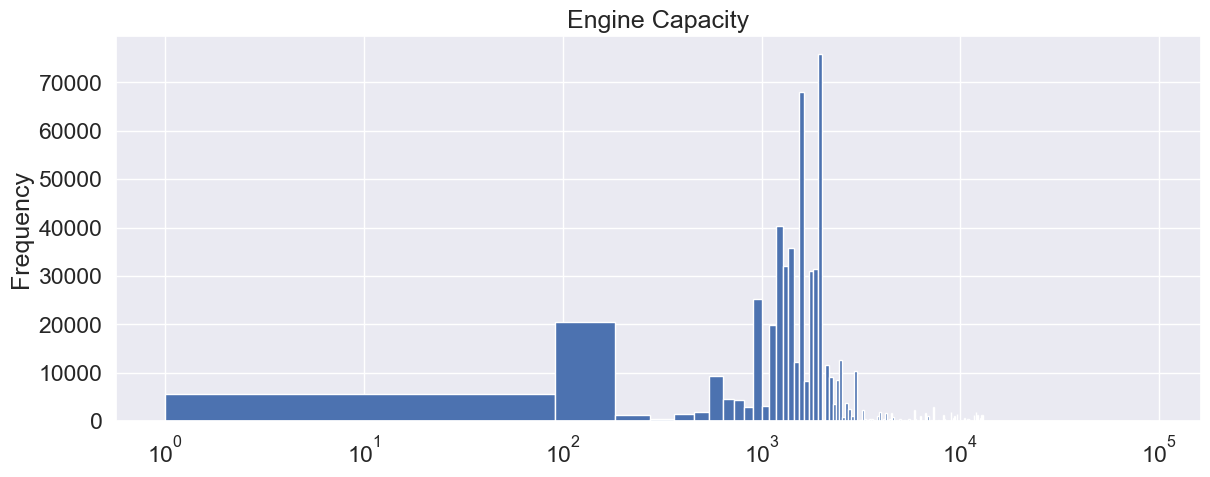

In [14]:
(df['Engine_Capacity_.CC.']
 .plot(kind='hist',  # Use 'kind' as a keyword argument
       bins=1000,
       title="Engine Capacity", 
       figsize=(14, 5),
       logx=True
      ))

print('Min:', df['Engine_Capacity_.CC.'].min(), '\n'
      'Max:', df['Engine_Capacity_.CC.'].max(), '\n'
      'Median:', df['Engine_Capacity_.CC.'].median())


## **2.5 Create a new dataframe** 
### with only the features we need and want, **25 features overall**

In [16]:
df2 = df[['Accident_Index', '1st_Road_Class','Day_of_Week', 'Junction_Detail','Light_Conditions', 'Number_of_Casualties',
          'Number_of_Vehicles', 'Road_Surface_Conditions', 'Road_Type', 'Special_Conditions_at_Site', 'Speed_limit',
          'Time', 'Urban_or_Rural_Area', 'Weather_Conditions', 'Age_Band_of_Driver', 'Age_of_Vehicle',
          'Hit_Object_in_Carriageway', 'Hit_Object_off_Carriageway', 'make', 'Engine_Capacity_.CC.', 'Sex_of_Driver',
          'Skidding_and_Overturning', 'Vehicle_Manoeuvre', 'Vehicle_Type', 'Accident_Severity'
         ]]

## **Correlation matrix**

In [18]:
print(df2.dtypes)


Accident_Index                 object
1st_Road_Class                 object
Day_of_Week                    object
Junction_Detail                object
Light_Conditions               object
Number_of_Casualties            int64
Number_of_Vehicles              int64
Road_Surface_Conditions        object
Road_Type                      object
Special_Conditions_at_Site     object
Speed_limit                   float64
Time                           object
Urban_or_Rural_Area            object
Weather_Conditions             object
Age_Band_of_Driver             object
Age_of_Vehicle                float64
Hit_Object_in_Carriageway      object
Hit_Object_off_Carriageway     object
make                           object
Engine_Capacity_.CC.          float64
Sex_of_Driver                  object
Skidding_and_Overturning       object
Vehicle_Manoeuvre              object
Vehicle_Type                   object
Accident_Severity              object
dtype: object


## **Number of vehicles distribution**

In [20]:
print(df2.dtypes)
numeric_df = df2.select_dtypes(include=['float64', 'int64'])

# Check for any NaN values and handle them
print(numeric_df.isnull().sum())

# Drop rows with NaN values if necessary
numeric_df.dropna(inplace=True)

Accident_Index                 object
1st_Road_Class                 object
Day_of_Week                    object
Junction_Detail                object
Light_Conditions               object
Number_of_Casualties            int64
Number_of_Vehicles              int64
Road_Surface_Conditions        object
Road_Type                      object
Special_Conditions_at_Site     object
Speed_limit                   float64
Time                           object
Urban_or_Rural_Area            object
Weather_Conditions             object
Age_Band_of_Driver             object
Age_of_Vehicle                float64
Hit_Object_in_Carriageway      object
Hit_Object_off_Carriageway     object
make                           object
Engine_Capacity_.CC.          float64
Sex_of_Driver                  object
Skidding_and_Overturning       object
Vehicle_Manoeuvre              object
Vehicle_Type                   object
Accident_Severity              object
dtype: object
Number_of_Casualties         0
Numbe

In [21]:
# Select only numeric columns
numeric_df = df2.select_dtypes(include=['float64', 'int64'])

# Check for any NaN values and handle them
print(numeric_df.isnull().sum())

# Drop rows with NaN values if necessary
numeric_df.dropna(inplace=True)


Number_of_Casualties         0
Number_of_Vehicles           0
Speed_limit                 14
Age_of_Vehicle          102303
Engine_Capacity_.CC.     75580
dtype: int64


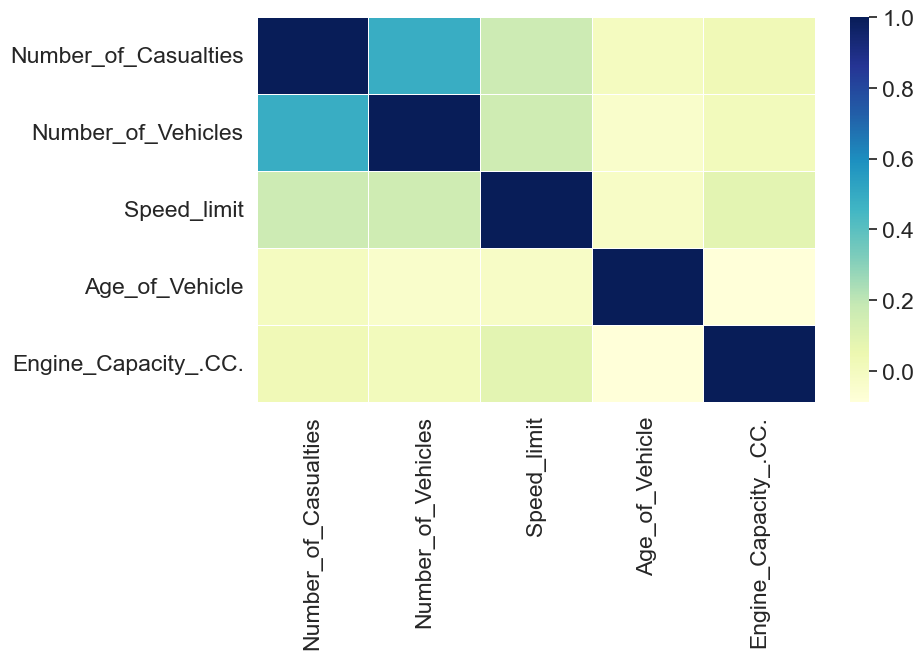

In [22]:
plt.figure(figsize=(9,5))
sns.heatmap(numeric_df.corr(), linewidths=.5, cmap="YlGnBu")
plt.show()

Min: 1 
Max: 67 
Median: 2.0


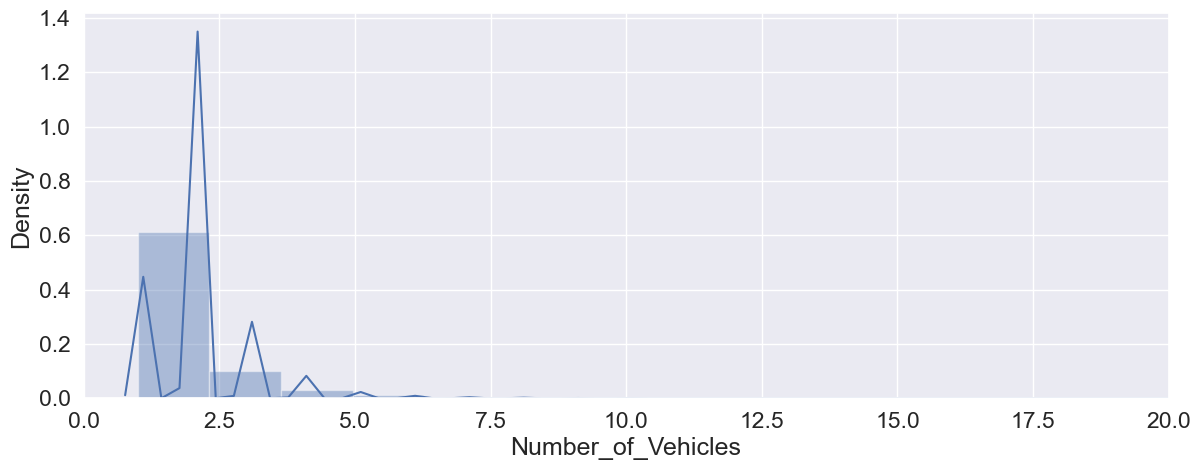

In [23]:
plt.figure(figsize=(14,5))
sns.distplot(df2.Number_of_Vehicles).set_xlim(0,20)
print('Min:',    df2.Number_of_Vehicles.min(), '\n'
      'Max:',    df2.Number_of_Vehicles.max(), '\n'
      'Median:', df2.Number_of_Vehicles.median())

## **Number of casualties distribution**

Min: 1 
Max: 87 
Median: 1.0


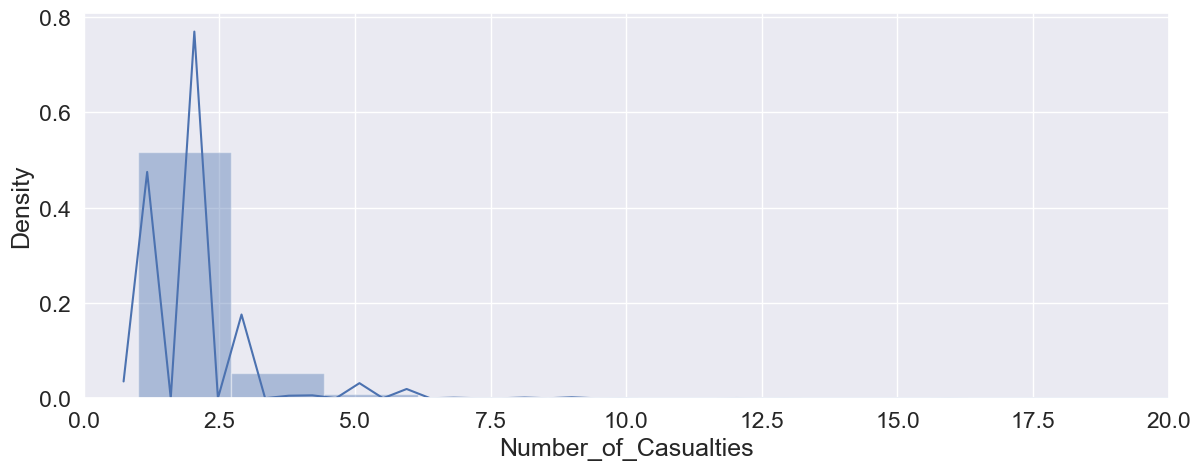

In [25]:
plt.figure(figsize=(14,5))
sns.distplot(df2.Number_of_Casualties).set_xlim(0,20)
print('Min:',    df2.Number_of_Casualties.min(), '\n'
      'Max:',    df2.Number_of_Casualties.max(), '\n'
      'Median:', df2.Number_of_Casualties.median())

## ** Distribution of accidents over the day**

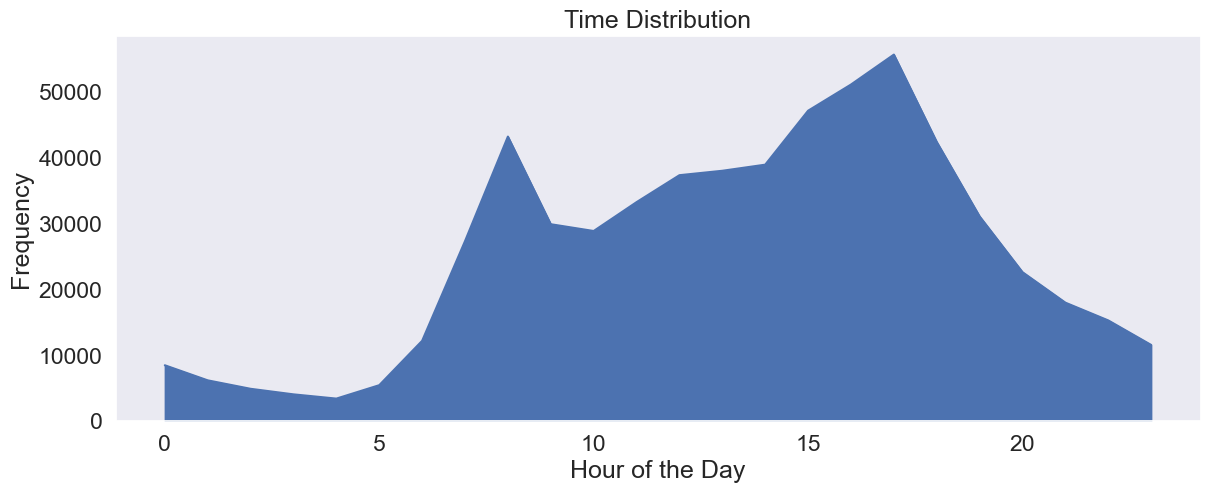

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'Time' to datetime and extract the hour
time_x = pd.to_datetime(df2['Time'], format='%H:%M').dt.hour

# Create a figure
plt.figure(figsize=(14, 5))

# Plot using the correct syntax
time_x.value_counts().sort_index().plot(kind='area')

# Show the plot
plt.title('Time Distribution')
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')
plt.grid()
plt.show()

## **From multiclass to two-classes**

In [29]:
df2['Accident_Severity'] = df2['Accident_Severity'].replace(['Serious', 'Fatal'], 'Serious or Fatal')
df2 = pd.get_dummies(df2, columns=['Accident_Severity'])
df2 = df2.drop('Accident_Severity_Serious or Fatal', axis=1)
df2.Accident_Severity_Slight.value_counts(normalize=True)

Accident_Severity_Slight
True     0.601056
False    0.398944
Name: proportion, dtype: float64

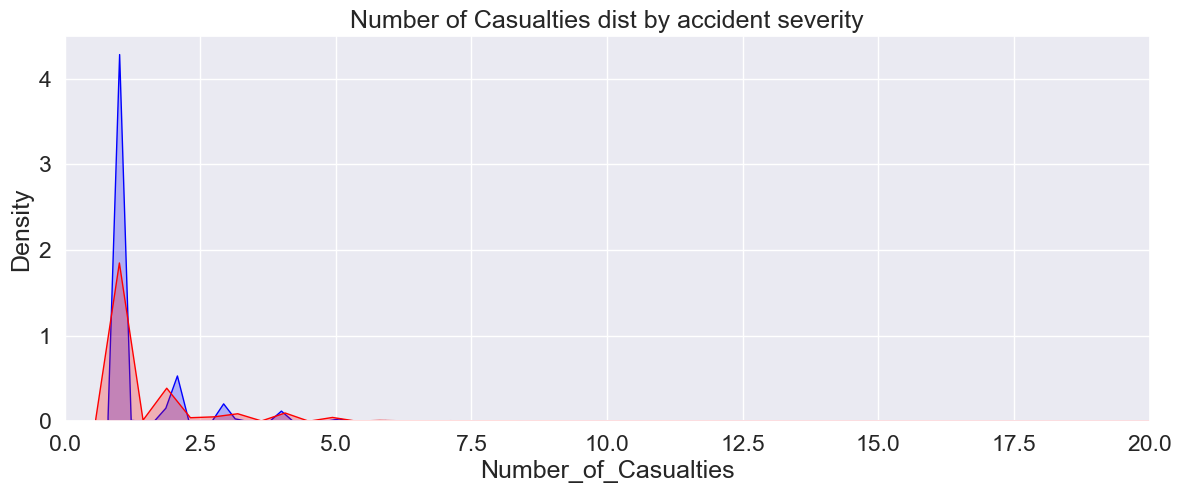

In [30]:
plt.figure(figsize=(14,5))
acc_slight = df2.Accident_Severity_Slight == 1
acc_severe = df2.Accident_Severity_Slight == 0

sns.kdeplot(df2.Number_of_Casualties[acc_slight],shade=True,color='Blue', label='Slight').set_xlim(0,20)
sns.kdeplot(df2.Number_of_Casualties[acc_severe],shade=True,color='Red', label='Severe').set_xlim(0,20)

plt.title('Number of Casualties dist by accident severity')
plt.show()

#print("we can see distribution between failed (under 2000), and successful (bigger the 2000)")


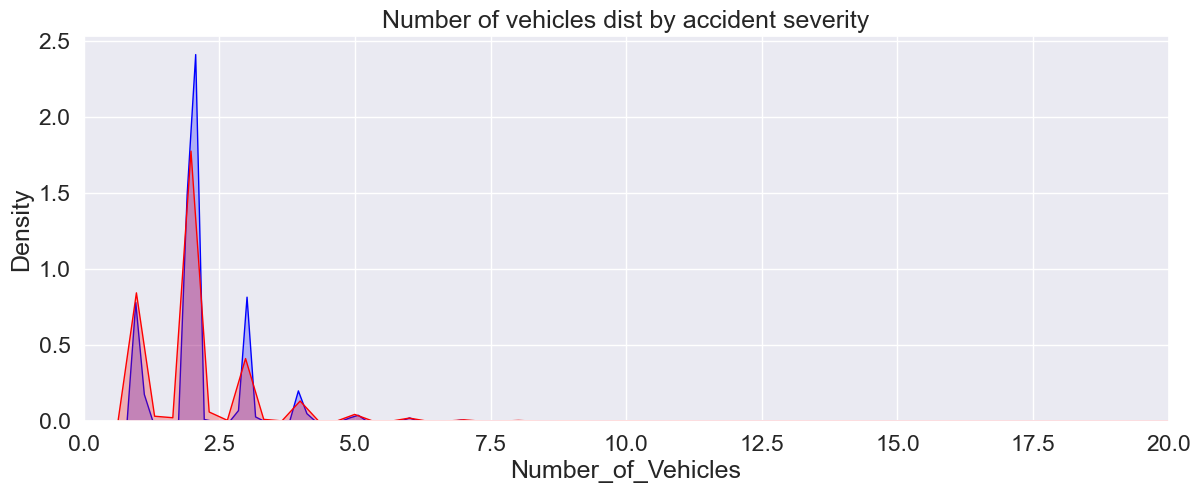

In [31]:
plt.figure(figsize=(14,5))

sns.kdeplot(df2.Number_of_Vehicles[acc_slight],shade=True,color='Blue', label='Slight').set_xlim(0,20)
sns.kdeplot(df2.Number_of_Vehicles[acc_severe],shade=True,color='Red', label='Severe').set_xlim(0,20)

plt.title('Number of vehicles dist by accident severity')
plt.show()

#print("we can see distribution between failed (under 2000), and successful (bigger the 2000)")


In [32]:
print(df2.dtypes)

Accident_Index                 object
1st_Road_Class                 object
Day_of_Week                    object
Junction_Detail                object
Light_Conditions               object
Number_of_Casualties            int64
Number_of_Vehicles              int64
Road_Surface_Conditions        object
Road_Type                      object
Special_Conditions_at_Site     object
Speed_limit                   float64
Time                           object
Urban_or_Rural_Area            object
Weather_Conditions             object
Age_Band_of_Driver             object
Age_of_Vehicle                float64
Hit_Object_in_Carriageway      object
Hit_Object_off_Carriageway     object
make                           object
Engine_Capacity_.CC.          float64
Sex_of_Driver                  object
Skidding_and_Overturning       object
Vehicle_Manoeuvre              object
Vehicle_Type                   object
Accident_Severity_Slight         bool
dtype: object


In [33]:
df2['Accident_Severity_Slight'] = pd.to_numeric(df2['Accident_Severity_Slight'], errors='coerce')


In [34]:
df2['Accident_Severity_Slight'].fillna(0, inplace=True)  # or use dropna() if appropriate


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
plt.subplots_adjust(hspace=1.4)

(df2.groupby(['Age_Band_of_Driver'])
 .mean()['Accident_Severity_Slight']
 .sort_index()
 .plot.bar(title="Mean Age Band of Driver vs. Accident Severity", ax=axes[0, 0]))

(df2.groupby(['Speed_limit'])
 .mean()['Accident_Severity_Slight']
 .sort_index()
 .plot.bar(title="Mean Speed Limit vs. Accident Severity", ax=axes[0, 1]))

(df2.groupby(['Urban_or_Rural_Area'])
 .mean()['Accident_Severity_Slight']
 .sort_index()
 .plot.bar(title="Mean Urban or Rural Area vs. Accident Severity", ax=axes[1, 0]))


## **2.6 Split features and targets from the data**

In [37]:
X = df2.drop(['Accident_Index','Accident_Severity_Slight'], axis=1)
y = df2.Accident_Severity_Slight
print(X.shape,
      y.shape)

(617522, 23) (617522,)


# **3. Training/Predicting Pipeline**
## **Transform Speed Limit**

In [39]:
def get_Speed_limit(df):
    return df[['Speed_limit']]

FullTransformerOnSpeedLimit = Pipeline([
    ("Select_Speed_Limit", FunctionTransformer(func=get_Speed_limit, validate=False)),
    ("Fill_Null", SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ("One_Hot_Encoder", OneHotEncoder(sparse_output=False, handle_unknown='ignore'))  # Changed 'sparse' to 'sparse_output'
])

# Uncomment to fit the transformer
# transformed_data = FullTransformerOnSpeedLimit.fit_transform(X[:5000], y[:5000])

## **Transform Time**

In [41]:
def get_Time(df):
    return pd.to_datetime(df['Time'], format='%H:%M').dt.time

def find_time_group(time_object):
    if time_object<pd.datetime.time(pd.datetime(2000,1,1,5,0)):
        return 'Night'
    elif time_object<pd.datetime.time(pd.datetime(2000,1,1,7,0)):
        return 'Early Morning'
    elif time_object<pd.datetime.time(pd.datetime(2000,1,1,10,0)):
        return 'Morning'
    elif time_object<pd.datetime.time(pd.datetime(2000,1,1,15,0)):
        return 'Midday'
    elif time_object<pd.datetime.time(pd.datetime(2000,1,1,18,0)):
        return 'Afternoon'
    elif time_object<pd.datetime.time(pd.datetime(2000,1,1,20,0)):
        return 'Evening'
    elif time_object<=pd.datetime.time(pd.datetime(2000,1,1,23,59)):
        return 'Late Evening'
    return np.nan

FullTransformerOnTime = Pipeline([("Select_Time",     FunctionTransformer(func=get_Time, validate=False)),
                                  ("Group_Time",      FunctionTransformer(func=lambda x: x.apply(find_time_group).to_frame(), validate=False)),
                                  ("Fill_Null",       SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                                  ("One_Hot_Encoder", OneHotEncoder(sparse_output = False, handle_unknown='ignore'))
                                 ])

#FullTransformerOnTime.fit_transform(X[:5000], y[:5000])

## **Transform Age of Vehicle**

In [43]:
def get_Age_of_Vehicle(df):
    return df[['Age_of_Vehicle']]

FullTransformerOnAgeofVehicle = Pipeline([("Select_Age_of_Vehicle", FunctionTransformer(func=get_Age_of_Vehicle, validate=False)),
                                          ("Fill_Null",             SimpleImputer(missing_values=np.nan, strategy='median'))
                                         ])

#FullTransformerOnAgeofVehicle.fit_transform(X[:5000], y[:5000])

## **Transform Make**

In [45]:
def get_make(df):
    list_of_small_makers = list(df['make'].value_counts()[df['make'].value_counts() < 2000].index)
    return df['make'].replace(list_of_small_makers, 'Other').to_frame()

FullTransformerOnMake = Pipeline([("Select_Make",      FunctionTransformer(func=get_make, validate=False)),
                                   ("Fill_Null",       SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Other')),
                                   ("One_Hot_Encoder", OneHotEncoder(sparse_output = False, handle_unknown='ignore'))])

#FullTransformerOnMake.fit_transform(X[:5000], y[:5000])

## **Transform Engine Capacity**

In [47]:
def get_Engine_Capacity(df):
    return df[['Engine_Capacity_.CC.']]

FullTransformerOnEngineCapacity = Pipeline([("Select_Engine_Capacity",       FunctionTransformer(func=get_Engine_Capacity, validate=False)),
                                            ("Fill_Null",                    SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                                            ("Car_Types_by_Engine_Capacity", KBinsDiscretizer(n_bins=7, encode='ordinal', strategy='quantile')),
                                            ("One_Hot_Encoder",              OneHotEncoder(sparse_output = False, handle_unknown='ignore'))
                                           ])

#FullTransformerOnEngineCapacity.fit_transform(X[:5000], y[:5000])
#FullTransformerOnEngineCapacity.named_steps["Car_Types_by_Engine_Capacity"].bin_edges_[0]

## **Data To OneHot Transformer On Columns**

In [49]:
def get_columns_to_one_hot(df):
    return df[['1st_Road_Class', 'Day_of_Week', 'Junction_Detail', 'Light_Conditions', 'Number_of_Casualties', 
               'Number_of_Vehicles', 'Road_Surface_Conditions', 'Road_Type', 'Special_Conditions_at_Site', 
               'Urban_or_Rural_Area', 'Weather_Conditions', 'Age_Band_of_Driver', 'Hit_Object_in_Carriageway',
               'Hit_Object_off_Carriageway', 'Sex_of_Driver', 'Skidding_and_Overturning',
               'Vehicle_Manoeuvre', 'Vehicle_Type'
              ]]

DataToOneHotTransformerOnColumns = Pipeline([("Select_Columns",  FunctionTransformer(func=get_columns_to_one_hot, validate=False)),
                                             ("One_Hot_Encoder", OneHotEncoder(sparse_output = False, handle_unknown='ignore'))])

#DataToOneHotTransformerOnColumns.fit_transform(X[:5000], y[:5000])

## **Feature Union**

In [51]:
FeatureUnionTransformer = FeatureUnion([
                                        ("FTAgeofVehicle",   FullTransformerOnAgeofVehicle),
                                        ("FTEngineCapacity", FullTransformerOnEngineCapacity),
                                        ("FTMake",           FullTransformerOnMake),
                                        ("FTSpeedLimit",     FullTransformerOnSpeedLimit),
                                        ("FTTime",           FullTransformerOnTime),
                                        ("OHEColumns",       DataToOneHotTransformerOnColumns)])

#FeatureUnionTransformer.fit_transform(X[:5000], y[:5000])

In [52]:
Full_Transformer = Pipeline([
                           ("Feature_Engineering", FeatureUnionTransformer),
                           ("Min_Max_Transformer", MaxAbsScaler())
                           ])

#Full_Transformer.fit(X[:5000], y[:5000])

In [53]:
from datetime import time
import numpy as np
import pandas as pd

def find_time_group(time_object):
    # Check if the time_object is NaT (Not a Time)
    if pd.isna(time_object):
        return np.nan  # Or return a specific group like 'Unknown'
    
    if time_object < time(5, 0):
        return 'Night'
    elif time_object < time(7, 0):
        return 'Early Morning'
    elif time_object < time(12, 0):
        return 'Morning'
    elif time_object < time(18, 0):
        return 'Afternoon'
    elif time_object < time(22, 0):
        return 'Evening'
    else:
        return 'Late Evening'

# Update the pipeline function
FullTransformerOnTime = Pipeline([
    ("Select_Time", FunctionTransformer(func=get_Time, validate=False)),
    ("Group_Time", FunctionTransformer(func=lambda x: x.apply(find_time_group), validate=False)),
    ("Fill_Null", SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ("One_Hot_Encoder", OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])


# **4. Prediction and submission**

In [55]:
X_train, X_test, y_train, y_test = split(X, y)

## **4.1 Logistic Regression**

Classification Report:               precision    recall  f1-score   support

       False       0.56      0.66      0.60     61503
        True       0.74      0.65      0.69     92878

    accuracy                           0.65    154381
   macro avg       0.65      0.66      0.65    154381
weighted avg       0.67      0.65      0.66    154381

Score: 0.7120174717745421


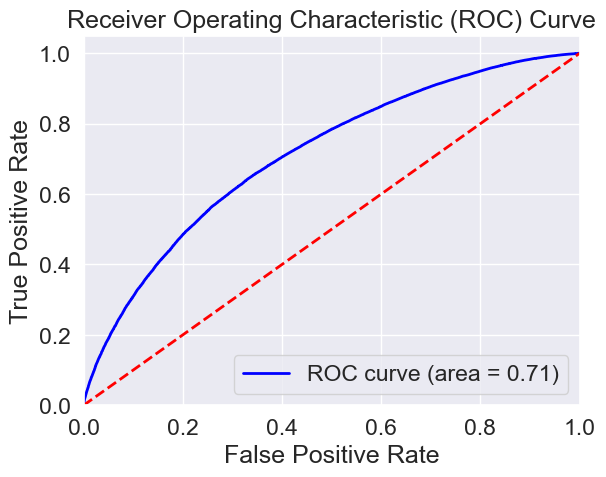

CPU times: total: 34.6 s
Wall time: 31.9 s


In [90]:
%%time

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Fit and transform data
clf = LogisticRegression(class_weight="balanced")

Full_Transformer.fit(X_train)
X_train_transformed = Full_Transformer.transform(X_train)
clf.fit(X_train_transformed, y_train)

X_test_transformed = Full_Transformer.transform(X_test)

# Predictions
y_pred = clf.predict(X_test_transformed)
y_pred_proba = clf.predict_proba(X_test_transformed)[:, 1]

# Print classification report and score
print('Classification Report:', classification_report(y_test, y_pred))
print('Score:', roc_auc_score(y_test.values, y_pred_proba))

# ROC AUC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## **4.2 XGBoost**

Classification Report:               precision    recall  f1-score   support

       False       0.65      0.48      0.55     61503
        True       0.71      0.83      0.76     92878

    accuracy                           0.69    154381
   macro avg       0.68      0.66      0.66    154381
weighted avg       0.69      0.69      0.68    154381

Score: 0.7359466755206653


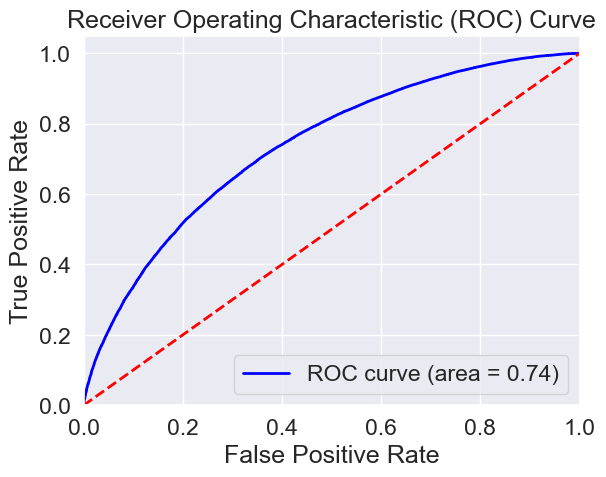

In [92]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc

# Create the XGBoost classifier
clf_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=3)

# Fit the transformer and transform the training data
Full_Transformer.fit(X_train)
X_train_transformed = Full_Transformer.transform(X_train)

# Fit the XGBoost model
clf_xgb.fit(X_train_transformed, y_train)

# Transform the test data
X_test_transformed = Full_Transformer.transform(X_test)

# Make predictions
y_pred_xgb = clf_xgb.predict(X_test_transformed)

# Print the classification report
print('Classification Report:', classification_report(y_test, y_pred_xgb))

# Calculate and print the ROC AUC score
roc_auc = roc_auc_score(y_test.values, clf_xgb.predict_proba(X_test_transformed)[:, 1])
print('Score:', roc_auc)

# ROC AUC Curve
y_pred_proba_xgb = clf_xgb.predict_proba(X_test_transformed)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_xgb)
roc_auc_curve = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_curve)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## **Decision Tree**

Decision Tree Classification Report:
              precision    recall  f1-score   support

       False       0.64      0.70      0.67     61503
        True       0.79      0.74      0.76     92878

    accuracy                           0.72    154381
   macro avg       0.71      0.72      0.71    154381
weighted avg       0.73      0.72      0.72    154381

Decision Tree ROC AUC Score: 0.7188846815370604


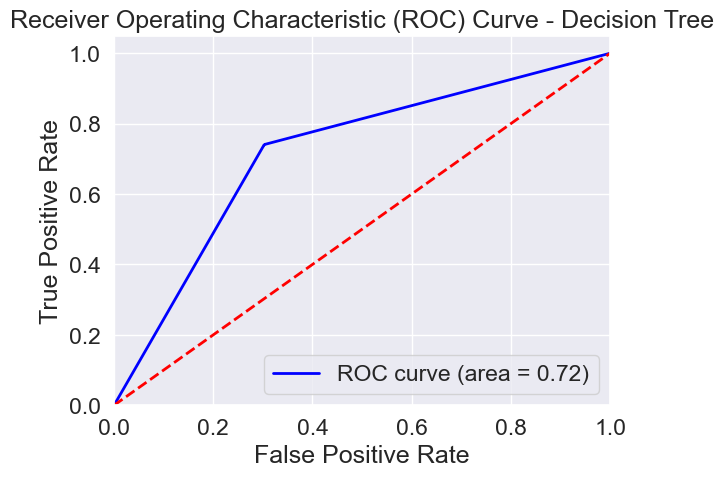

In [99]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc

# Create and train the Decision Tree model
dt_clf = DecisionTreeClassifier(random_state=42)

# Fit the transformer and transform the training data
Full_Transformer.fit(X_train)
X_train_transformed = Full_Transformer.transform(X_train)

# Fit the Decision Tree model
dt_clf.fit(X_train_transformed, y_train)

# Transform the test data
X_test_transformed = Full_Transformer.transform(X_test)

# Make predictions
y_pred_dt = dt_clf.predict(X_test_transformed)

# Print the classification report
print('Decision Tree Classification Report:')
print(classification_report(y_test, y_pred_dt))

# Calculate and print the ROC AUC score
roc_auc = roc_auc_score(y_test.values, dt_clf.predict_proba(X_test_transformed)[:, 1])
print('Decision Tree ROC AUC Score:', roc_auc)

# ROC AUC Curve
y_pred_proba_dt = dt_clf.predict_proba(X_test_transformed)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_dt)
roc_auc_curve = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_curve)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Decision Tree')
plt.legend(loc='lower right')
plt.show()

## **4.2 Random Forest Classifier**

Classification Report:               precision    recall  f1-score   support

       False       0.78      0.68      0.73     61503
        True       0.80      0.88      0.84     92878

    accuracy                           0.80    154381
   macro avg       0.79      0.78      0.78    154381
weighted avg       0.80      0.80      0.79    154381

Score: 0.861225568181327


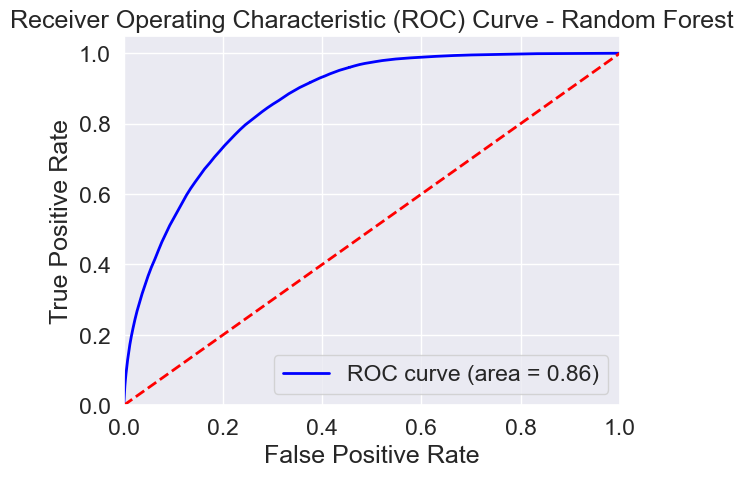

In [105]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc

# Start timing


# Create and train the Random Forest model
clf = RandomForestClassifier(n_estimators=100, n_jobs=3)

# Fit the transformer and transform the training data
Full_Transformer.fit(X_train)
X_train_transformed = Full_Transformer.transform(X_train)

# Fit the Random Forest model
clf.fit(X_train_transformed, y_train)

# Transform the test data
X_test_transformed = Full_Transformer.transform(X_test)

# Make predictions
y_pred = clf.predict(X_test_transformed)

# Print the classification report
print('Classification Report:', classification_report(y_test, y_pred))

# Calculate and print the ROC AUC score
roc_auc = roc_auc_score(y_test.values, clf.predict_proba(X_test_transformed)[:, 1])
print('Score:', roc_auc)

# ROC AUC Curve
y_pred_proba = clf.predict_proba(X_test_transformed)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc_curve = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_curve)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.legend(loc='lower right')
plt.show()


## **4.3 Using the Full Estimator**
## Logistic Regression

In [67]:
RandomForest_Full_Estimator = Pipeline([
                                        ("Feature_Engineering", FeatureUnionTransformer),
                                        ("Min_Max_Transformer", MaxAbsScaler()),
                                        ("Clf",                 RandomForestClassifier(n_estimators=100, n_jobs=3))
                                       ])

#RandomForest_Full_Estimator.fit(X[:5000], y[:5000])